# GAN 구현_CIFAR-10

## 1 데이터 준비: CIFAR-10

- CIFAR-10은 32x32 크기의 컬러 이미지 데이터셋으로, 10개의 클래스를 포함합니다.
- 데이터 로드 및 전처리: 이미지를 [-1, 1] 범위로 정규화하여 Generator의 출력과 일치시킵니다.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # RGB 각각 [-1, 1]로 정규화
])

# CIFAR-10 데이터셋 로드
batch_size = 128
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## 2. Generator 네트워크 구현


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 입력: 잠재 벡터 z, 크기: nz x 1 x 1
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 크기: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 크기: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 크기: 128 x 16 x 16
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 출력: 3 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

- nz: 잠재 공간 벡터의 크기 (예: 100).
- 입력 차원: (batch_size, nz, 1, 1) 형태의 잠재 벡터.
- nn.ConvTranspose2d: 입력을 업샘플링하여 출력의 공간 차원을 증가시킵니다.

## 3 Discriminator 네트워크 구현

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 입력: 3 x 32 x 32
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # 출력: 1
        )

    def forward(self, input):
        return self.main(input).view(-1)

- nn.Conv2d: 입력 이미지를 다운샘플링하여 특징을 추출합니다.
- 출력 차원: 실수 스칼라 값으로, 입력 이미지가 실제일 확률을 나타냅니다.

## 4. 손실 함수와 옵티마이저 설정

In [ ]:
import torch.optim as optim

# 모델 초기화
nz = 100  # 잠재 벡터 크기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# 손실 함수
criterion = nn.BCELoss()

# Generator의 잠재 벡터 입력
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 옵티마이저 설정
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 5. GAN 학습 과정 구현

In [ ]:
# T4 기준 -> 25분 정도
num_epochs = 25

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Discriminator 네트워크 훈련
        ###########################
        ## 진짜 데이터로 훈련
        netD.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)  # 진짜 레이블: 1
        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터로 훈련
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)  # 가짜 레이블: 0
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Generator 네트워크 훈련
        ###########################
        netG.zero_grad()
        label.fill_(1.)  # Generator는 Discriminator를 속이기 위해 진짜 레이블 사용
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 학습 상태 출력
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\t'
                  f'Loss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')


[0/25][0/391]	Loss_D: 1.4199	Loss_G: 3.4018	D(x): 0.4307	D(G(z)): 0.4238/0.0349
[0/25][100/391]	Loss_D: 0.2148	Loss_G: 13.4324	D(x): 0.9808	D(G(z)): 0.1767/0.0000
[0/25][200/391]	Loss_D: 0.0796	Loss_G: 5.3667	D(x): 0.9656	D(G(z)): 0.0423/0.0054
[0/25][300/391]	Loss_D: 0.6797	Loss_G: 2.7363	D(x): 0.6218	D(G(z)): 0.0950/0.0985
[1/25][0/391]	Loss_D: 0.4026	Loss_G: 2.7561	D(x): 0.8620	D(G(z)): 0.2074/0.0848
[1/25][100/391]	Loss_D: 0.7330	Loss_G: 2.6752	D(x): 0.6711	D(G(z)): 0.2238/0.0889
[1/25][200/391]	Loss_D: 0.8812	Loss_G: 5.1265	D(x): 0.8999	D(G(z)): 0.4723/0.0099
[1/25][300/391]	Loss_D: 0.7675	Loss_G: 2.0331	D(x): 0.5932	D(G(z)): 0.1202/0.1714
[2/25][0/391]	Loss_D: 0.8518	Loss_G: 3.8227	D(x): 0.8484	D(G(z)): 0.4441/0.0300
[2/25][100/391]	Loss_D: 0.5628	Loss_G: 2.9304	D(x): 0.8082	D(G(z)): 0.2663/0.0635
[2/25][200/391]	Loss_D: 0.5604	Loss_G: 2.8913	D(x): 0.7887	D(G(z)): 0.2425/0.0713
[2/25][300/391]	Loss_D: 0.3258	Loss_G: 2.6585	D(x): 0.7850	D(G(z)): 0.0591/0.0959
[3/25][0/391]	Loss_D:

- detach(): 생성된 이미지를 판별자에 입력할 때, 생성자의 그래프에서 분리하여 역전파 시 생성자의 가중치가 업데이트되지 않도록 합니다.
- label.fill_(): 레이블 값을 변경합니다.

- Discriminator 훈련
    - 진짜 이미지에 대한 손실 계산 및 역전파.
    - 가짜 이미지에 대한 손실 계산 및 역전파.
    - 두 손실을 합산하여 Discriminator 업데이트.

- Generator 훈련
    - 생성된 이미지를 Discriminator에 통과시켜 손실 계산.
    - Generator의 가중치를 업데이트하여 Discriminator를 속이도록 학습.

## 6. 결과 해석 및 시각화

### 6.1 생성된 이미지 시각화

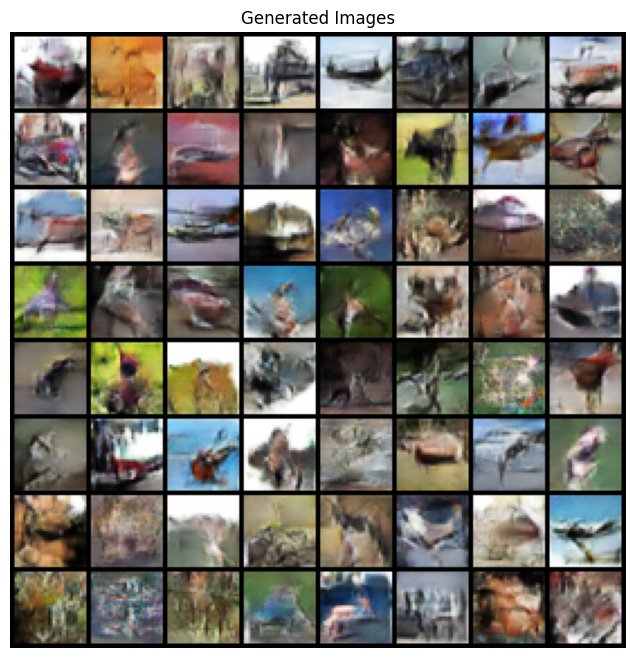

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 고정된 노이즈로부터 생성된 이미지 시각화
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list = torchvision.utils.make_grid(fake, padding=2, normalize=True)

# 시각화
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list, (1,2,0)))
plt.show()

- 학습이 진행됨에 따라 생성된 이미지의 품질이 향상됩니다.
- 초기에는 랜덤 노이즈와 유사한 이미지가 생성되지만, 에포크가 증가하면서 CIFAR-10 이미지와 유사한 이미지가 생성됩니다.


## 6.2 학습 과정 모니터링

- Discriminator와 Generator의 loss 변화를 모니터링하여 학습이 정상적으로 진행되는지 확인합니다.
- Discriminator의 출력 값 $D(x)$와 $D(G(z))$를 통해 Discriminator가 얼마나 정확하게 분류하고 있는지 알 수 있습니다.

## 7. GAN의 한계와 개선 방법

### 7.1 모수 조정의 어려움
- GAN은 학습이 불안정하며, Generator와 Discriminator의 학습 균형을 맞추기가 어렵습니다.
- 하이퍼파라미터(학습률, 배치 크기 등)의 조정이 성능에 큰 영향을 미칩니다.

### 7.2 학습 불안정성
- 모드 붕괴(mode collapse): Generator가 다양한 데이터를 생성하지 못하고 일부 모드에만 집중하는 현상.
- 이를 해결하기 위해 다양한 손실 함수와 학습 기법이 제안되었습니다.

### 7.3 개선된 GAN 모델 소개
- Wasserstein GAN(WGAN): Wasserstein distance를 사용하여 안정적인 학습을 도모.
- Least Squares GAN(LSGAN): 2차 손실 함수를 사용하여 학습 안정화.
- Progressive GAN: Generator와 Discriminator의 네트워크 깊이를 점진적으로 늘려 고해상도 이미지를 생성.

### 실습 / 탐구

하지만, 컴퓨팅 파워가 아쉬우신 분들은 레퍼런스 자료를 찾아보시면서 어떤 차이가 있을지 추론해보시고, 예상과 같은 지 다른 지를 노션 페이지에 공유해주세요.

- 하이퍼파라미터 조정: 학습률, 배치 크기, 에포크 수 등을 변경하여 학습 성능의 변화를 관찰해보세요.
- 데이터셋 변경: CelebA 등 다른 이미지 데이터셋으로 실험해보세요.
- 모델 개선: WGAN, LSGAN 등 개선된 GAN 모델을 구현하여 학습 안정성을 향상시켜보세요.
- 모드 붕괴 관찰: 생성된 이미지의 다양성을 평가하여 모드 붕괴 현상을 확인하고 해결 방법을 모색해보세요.